# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [2]:
#Import all the required libraries

!pip install wordcloud
!pip install gTTs
!pip install playsound

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #for plotting graphs
import seaborn as sns 
import glob

from skimage import io
pd.set_option('display.max_colwidth',None) # Set the max column width to see the complete caption

import collections
from wordcloud import WordCloud,STOPWORDS

import tensorflow as tf
import keras
from keras.preprocessing.image import load_img
import string
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input
from tqdm import tqdm
from PIL import Image

from gtts import gTTS
from playsound import playsound
from IPython import display

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [6]:
#Import the dataset and read the image into a seperate variable

images='C:/Flickr8K/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


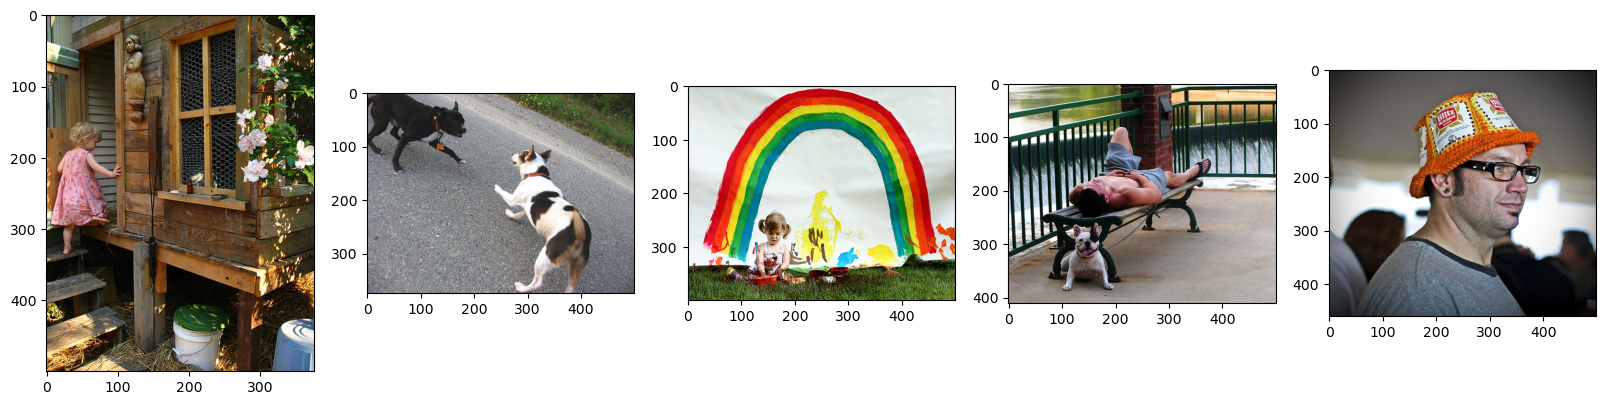

In [7]:
#Visualise both the images & text present in the dataset

#Visualising first 5 images:

Display_Images= all_imgs[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)
   
for ax,image in zip(axes, Display_Images):
    ax.imshow(io.imread(image), cmap=None)

In [8]:
#Import the dataset and read the text file into a seperate variable

text_file = 'C:/Flickr8K/captions.txt'

def load_doc(text_file):
    
    #your code here
    open_file = open(text_file, 'r', encoding="latin-1") #associate and returns a file object
    text = open_file.read() #for reading the content of the file
    print(text)
    open_file.close()    
    return text

doc = load_doc(text_file)
print(doc[:300])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [9]:
all_imgs

['C:/Flickr8K/Images\\1000268201_693b08cb0e.jpg',
 'C:/Flickr8K/Images\\1001773457_577c3a7d70.jpg',
 'C:/Flickr8K/Images\\1002674143_1b742ab4b8.jpg',
 'C:/Flickr8K/Images\\1003163366_44323f5815.jpg',
 'C:/Flickr8K/Images\\1007129816_e794419615.jpg',
 'C:/Flickr8K/Images\\1007320043_627395c3d8.jpg',
 'C:/Flickr8K/Images\\1009434119_febe49276a.jpg',
 'C:/Flickr8K/Images\\1012212859_01547e3f17.jpg',
 'C:/Flickr8K/Images\\1015118661_980735411b.jpg',
 'C:/Flickr8K/Images\\1015584366_dfcec3c85a.jpg',
 'C:/Flickr8K/Images\\101654506_8eb26cfb60.jpg',
 'C:/Flickr8K/Images\\101669240_b2d3e7f17b.jpg',
 'C:/Flickr8K/Images\\1016887272_03199f49c4.jpg',
 'C:/Flickr8K/Images\\1019077836_6fc9b15408.jpg',
 'C:/Flickr8K/Images\\1019604187_d087bf9a5f.jpg',
 'C:/Flickr8K/Images\\1020651753_06077ec457.jpg',
 'C:/Flickr8K/Images\\1022454332_6af2c1449a.jpg',
 'C:/Flickr8K/Images\\1022454428_b6b660a67b.jpg',
 'C:/Flickr8K/Images\\1022975728_75515238d8.jpg',
 'C:/Flickr8K/Images\\102351840_323e3de834.jpg',
 'C

In [10]:
image_path='C:/Flickr8K/Images/'
all_img_id=[]  #store all the image id here
all_img_vector=[] #store all the image path here
annotations= []#store all the captions here

with open('C:/Flickr8K/captions.txt', 'r') as fo:
    next(fo) # to skip the heading 
    for line in fo:
        split_arr=line.split(',')
        all_img_id.append(split_arr[0])
        annotations.append(split_arr[1].rstrip('\n.')) #striping \n and fullstop
        all_img_vector.append(image_path+split_arr[0])
        
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

ID  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
40450   997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   

                                               Path  \
0      C:/Flickr8K/Images/1000268201_693b08cb0e.jpg   
1      C:/Flickr8K/Images/1000268201_693b08cb0e.jpg   
2      C:/Flickr8K/Images/1000268201_693b08cb0e.jpg   
3      C:/Flickr8K/Images/1000268201_693b08cb0e.jpg   
4      C:/Flickr8K/Images/1000268201_693b08cb0e.jpg   
...                                             ...   
40450   C:/Flickr8K/Images/997722733_0cb5439472.jpg   
40451   C:/Flickr8K/Images/997722733_0cb5439472.jpg   
40452   C:/Flickr8K/Images/997722733_0cb5439472.jpg   
40453   C:/Flickr8K/Images/997722733_0cb5439472.jpg   
40454   C:/Flickr8K/Images/997722733_0cb5439472.jpg   

                                                                         Captions  
0         A child in a pink dress is climbing up a set of stairs in an entry way   
1                                            A girl going into a wooden building   
2                                 A little girl climbing into a wooden playhouse   
3                             A little girl climbing the stairs to her playhouse   
4                        A little girl in a pink dress going into a wooden cabin   
...                                                                           ...  
40450                                    A man in a pink shirt climbs a rock face  
40451                                     A man is rock climbing high in the air   
40452  A person in a red shirt climbing up a rock face covered in assist handles   
40453                                              A rock climber in a red shirt   
40454                           A rock climber practices on a rock climbing wall   

[40455 rows x 3 columns]

In [11]:
type(annotations)

list

In [12]:
len(annotations)

40455

In [13]:
vocabulary= [word for line in annotations for word in line.split()]
vocabulary


['A',
 'child',
 'in',
 'a',
 'pink',
 'dress',
 'is',
 'climbing',
 'up',
 'a',
 'set',
 'of',
 'stairs',
 'in',
 'an',
 'entry',
 'way',
 'A',
 'girl',
 'going',
 'into',
 'a',
 'wooden',
 'building',
 'A',
 'little',
 'girl',
 'climbing',
 'into',
 'a',
 'wooden',
 'playhouse',
 'A',
 'little',
 'girl',
 'climbing',
 'the',
 'stairs',
 'to',
 'her',
 'playhouse',
 'A',
 'little',
 'girl',
 'in',
 'a',
 'pink',
 'dress',
 'going',
 'into',
 'a',
 'wooden',
 'cabin',
 'A',
 'black',
 'dog',
 'and',
 'a',
 'spotted',
 'dog',
 'are',
 'fighting',
 'A',
 'black',
 'dog',
 'and',
 'a',
 'tri-colored',
 'dog',
 'playing',
 'with',
 'each',
 'other',
 'on',
 'the',
 'road',
 'A',
 'black',
 'dog',
 'and',
 'a',
 'white',
 'dog',
 'with',
 'brown',
 'spots',
 'are',
 'staring',
 'at',
 'each',
 'other',
 'in',
 'the',
 'street',
 'Two',
 'dogs',
 'of',
 'different',
 'breeds',
 'looking',
 'at',
 'each',
 'other',
 'on',
 'the',
 'road',
 'Two',
 'dogs',
 'on',
 'pavement',
 'moving',
 'towa

**We can see that we had both A and a are counted separately. So,let's convert all words to lower case.**

In [14]:
#Create the vocabulary & the counter for the captions

vocabulary= [word.lower() for line in annotations for word in line.split()] #We can see that we had both

val_count=collections.Counter(vocabulary)
val_count

Counter({'a': 60196,
         'child': 1507,
         'in': 18174,
         'pink': 702,
         'dress': 332,
         'is': 9069,
         'climbing': 490,
         'up': 1215,
         'set': 105,
         'of': 6495,
         'stairs': 109,
         'an': 2325,
         'entry': 1,
         'way': 48,
         'girl': 3277,
         'going': 145,
         'into': 1046,
         'wooden': 278,
         'building': 485,
         'little': 1736,
         'playhouse': 6,
         'the': 17507,
         'to': 3005,
         'her': 1102,
         'cabin': 4,
         'black': 3620,
         'dog': 7948,
         'and': 8057,
         'spotted': 36,
         'are': 3365,
         'fighting': 130,
         'tri-colored': 12,
         'playing': 1954,
         'with': 7304,
         'each': 399,
         'other': 667,
         'on': 10357,
         'road': 380,
         'white': 3706,
         'brown': 2457,
         'spots': 28,
         'staring': 57,
         'at': 2810,
         'stree

a :  60196
in :  18174
the :  17507
on :  10357
is :  9069
and :  8057
dog :  7948
with :  7304
man :  7137
of :  6495
two :  5132
white :  3706
black :  3620
boy :  3514
are :  3365
woman :  3304
girl :  3277
to :  3005
wearing :  2916
people :  2811
at :  2810
water :  2676
young :  2587
red :  2553
brown :  2457
an :  2325
his :  2255
blue :  2125
dogs :  2095
running :  1996


Text(0, 0.5, 'Counts')

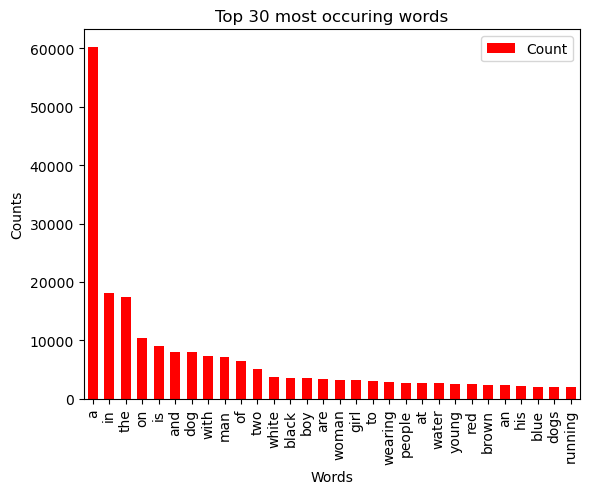

In [15]:
#Visualise the top 30 occuring words in the captions

#write your code here
for word, count in val_count.most_common(30):
    print(word, ": ", count)

lst = val_count.most_common(30)
most_common_words_df = pd.DataFrame(lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word',y='Count',width=0.6,color='red')
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")


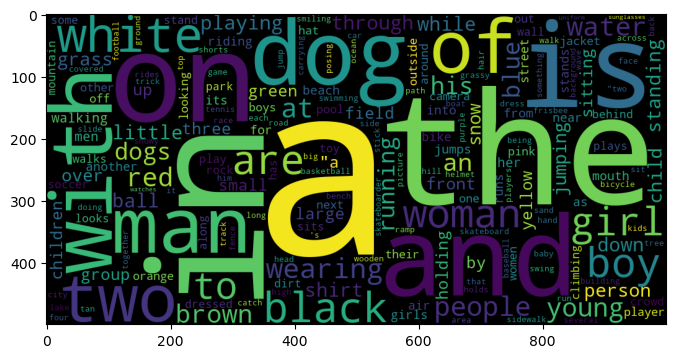

In [16]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(val_count)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)

We can see that stopwords are having higher frequency.Let's find top 30 commom words excluding them.

dog :  7948
man :  7137
two :  5132
white :  3706
black :  3620
boy :  3514
woman :  3304
girl :  3277
wearing :  2916
people :  2811
water :  2676
young :  2587
red :  2553
brown :  2457
blue :  2125
dogs :  2095
running :  1996
playing :  1954
little :  1736
shirt :  1735
standing :  1702
ball :  1678
grass :  1565
person :  1515
child :  1507
snow :  1439
jumping :  1430
front :  1322
sitting :  1322
small :  1257


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'dog'),
  Text(1, 0, 'man'),
  Text(2, 0, 'two'),
  Text(3, 0, 'white'),
  Text(4, 0, 'black'),
  Text(5, 0, 'boy'),
  Text(6, 0, 'woman'),
  Text(7, 0, 'girl'),
  Text(8, 0, 'wearing'),
  Text(9, 0, 'people'),
  Text(10, 0, 'water'),
  Text(11, 0, 'young'),
  Text(12, 0, 'red'),
  Text(13, 0, 'brown'),
  Text(14, 0, 'blue'),
  Text(15, 0, 'dogs'),
  Text(16, 0, 'running'),
  Text(17, 0, 'playing'),
  Text(18, 0, 'little'),
  Text(19, 0, 'shirt'),
  Text(20, 0, 'standing'),
  Text(21, 0, 'ball'),
  Text(22, 0, 'grass'),
  Text(23, 0, 'person'),
  Text(24, 0, 'child'),
  Text(25, 0, 'snow'),
  Text(26, 0, 'jumping'),
  Text(27, 0, 'front'),
  Text(28, 0, 'sitting'),
  Text(29, 0, 'small')])

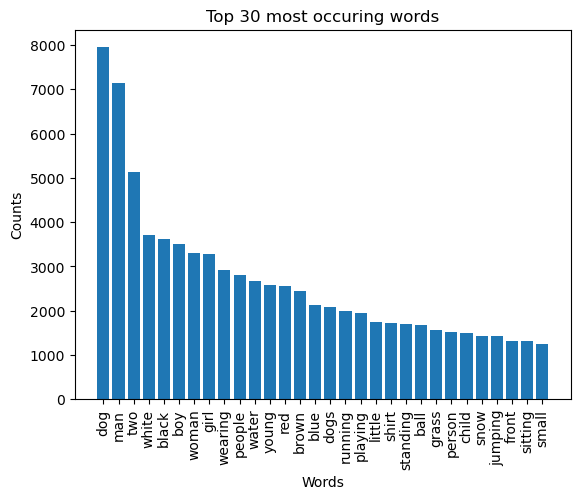

In [17]:
for word, count in val_count.most_common(47):
    if word not in STOPWORDS:
        print(word, ": ", count)

dict_without_stopwords = {}
for word, count in val_count.most_common(47):
    if word not in STOPWORDS:
        dict_without_stopwords[word] = count


#plt.bar(*zip(*dict_without_stopwords.items()))
#plt.show()
plt.bar(range(len(dict_without_stopwords)), dict_without_stopwords.values(), align='center')
plt.xticks(range(len(dict_without_stopwords)), list(dict_without_stopwords.keys()))
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")
plt.xticks(rotation=90)



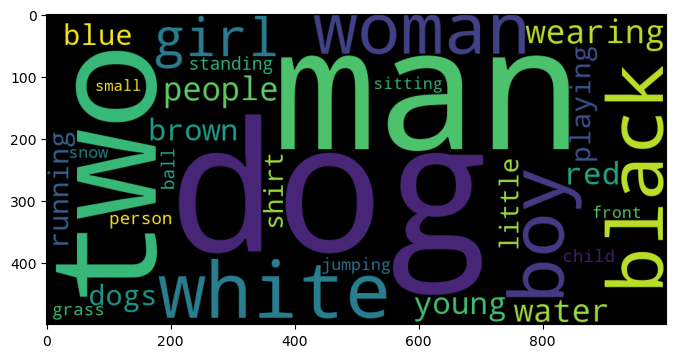

In [18]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(dict_without_stopwords)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)

C:\Users\amlan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


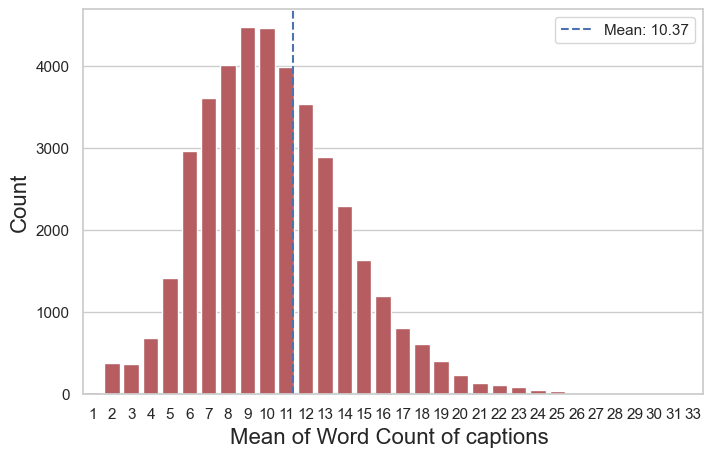

In [19]:
caption_df=df.copy()
caption_df['caption_word_count'] = caption_df["Captions"].str.split().str.len()

mean = sum(caption_df['caption_word_count'])/len(caption_df['caption_word_count'])

sns.set(style="whitegrid", font_scale = 1)
plt.figure(figsize=(8, 5))
ax = sns.countplot(caption_df['caption_word_count'], color="r")
plt.xlabel('Mean of Word Count of captions ', fontsize=16)
plt.ylabel('Count', fontsize=16)
ax.axvline(mean, color='b', linestyle='--')
plt.legend({'Mean: {:.2f}'.format(mean): mean})


C:\Users\amlan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


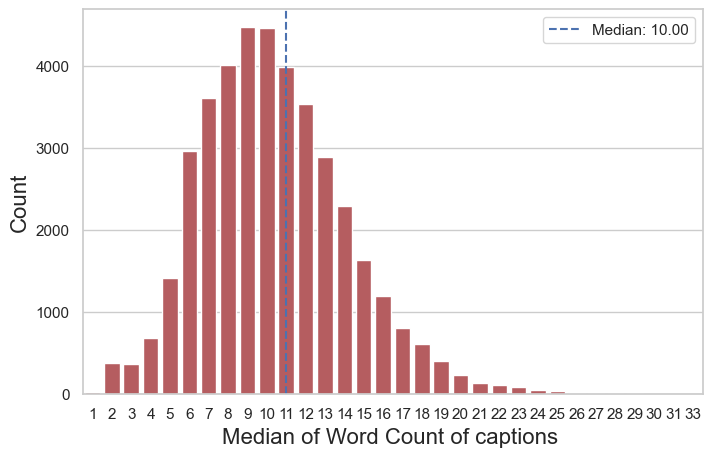

In [20]:
mean = np.median(caption_df['caption_word_count'])

sns.set(style="whitegrid", font_scale = 1)
plt.figure(figsize=(8, 5))
ax = sns.countplot(caption_df['caption_word_count'], color="r")
plt.xlabel('Median of Word Count of captions ', fontsize=16)
plt.ylabel('Count', fontsize=16)
ax.axvline(mean, color='b', linestyle='--')
plt.legend({'Median: {:.2f}'.format(mean): mean})

**We can see that most of the captions have 10 to 11 words**

### Until now we visualized the images and captions separately.Now let's visualize both of them together.


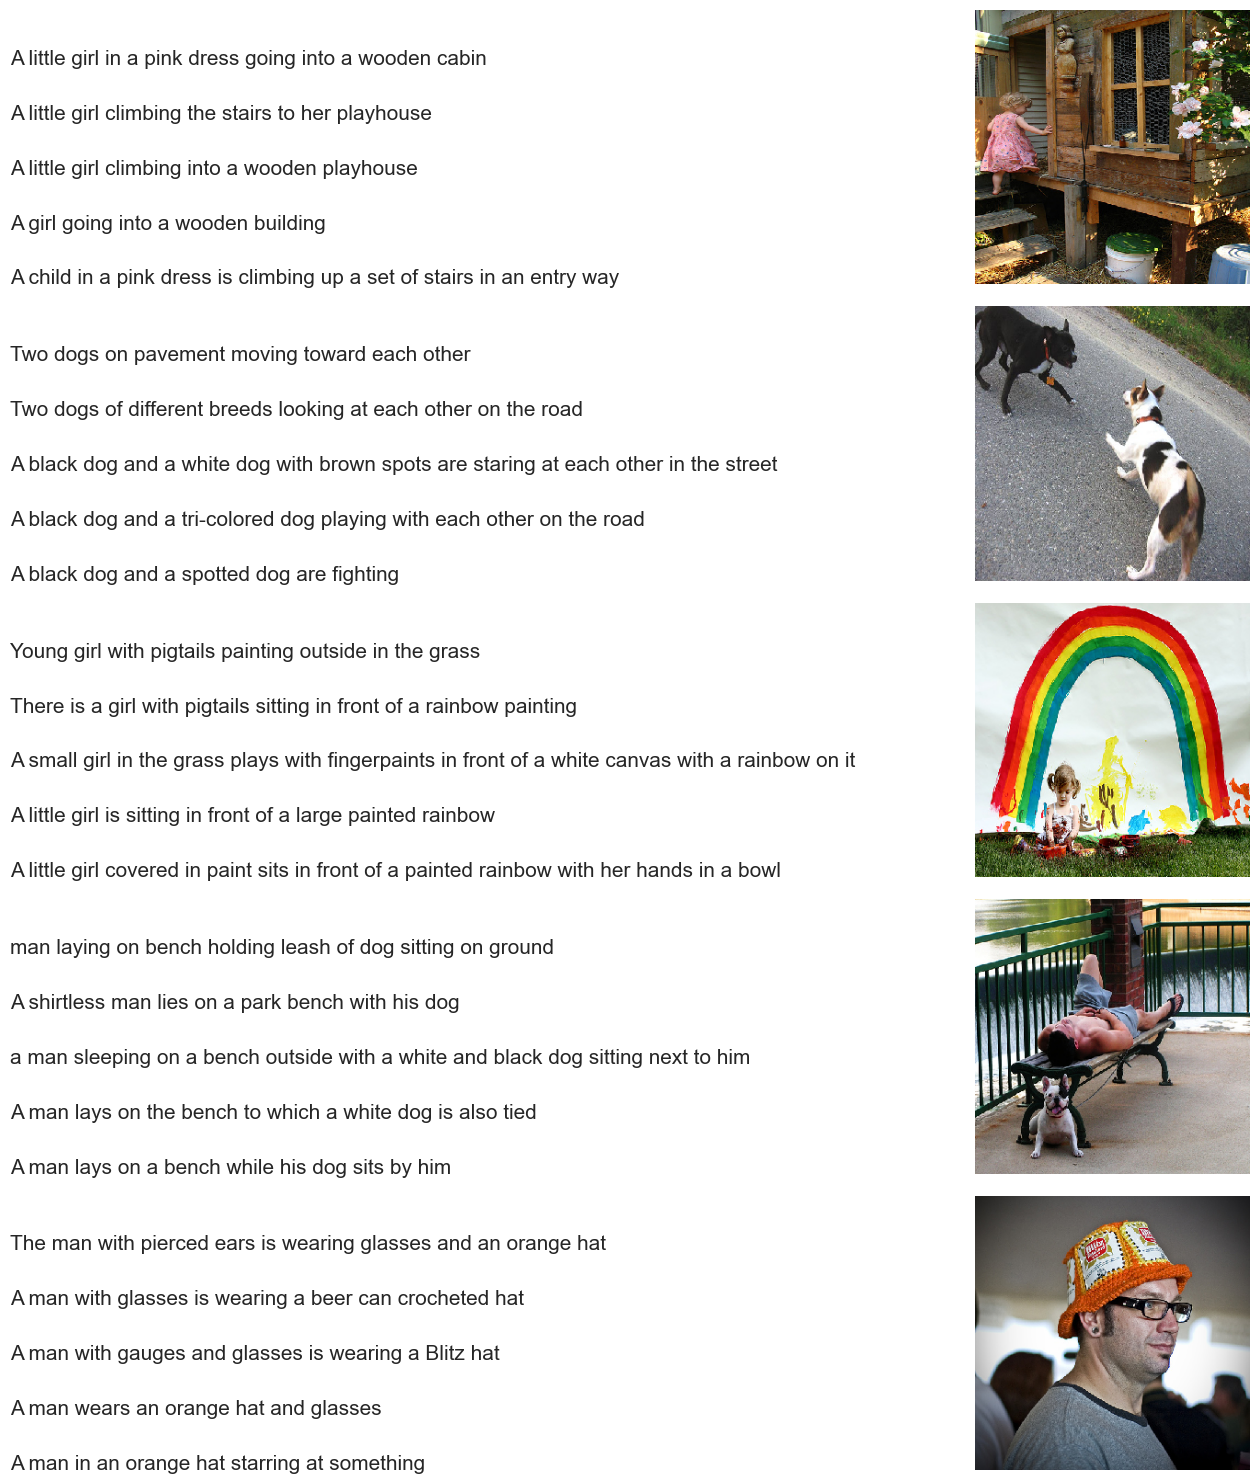

In [21]:
# Images 

fig = plt.figure(figsize=(15,15)) # For dosplaying image
count = 1
    
for Path in df[:25].Path.unique(): # Loading 1st 25 paths which will have 5 distinct images
    captions = list(df["Captions"].loc[df.Path== Path].values)
    display_image = load_img(Path,target_size=(299,299,3))
    ax = fig.add_subplot(5,2,count) #Adding a subplot that spans 5 rows:
    plt.axis('off')  # we don't want both x and y axes for caption 
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions)) #to decide the spacing between each line of caption
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=15)  #to display the captions         
    count+=1
    plt.tight_layout() #to make sure that image and caption don't overlap

    ax = fig.add_subplot(5,2,count)
    ax.imshow(display_image)
    plt.axis('off')
    count +=1

plt.show()



### Data Cleaning

- Converting all words to lower case
- Removing punctuations
- Retaining only words by removing numbers
- We are not removing stopwords but removing hanging s ,a or any one letter word.
- We are not performing stemming. 

In [22]:
# Data cleaning
# prepare translation table for removing punctuation
remove_punctuation = str.maketrans('', '', string.punctuation)
for i in range(len(annotations)):
    line = annotations[i]
    line = line.split()
    line = [word.lower() for word in line] # convert to lower case
    line = [word.translate(remove_punctuation) for word in line]# remove punctuation from each token
    line = [word for word in line if len(word)>1] # remove hanging 's' and 'a'
    line = [word for word in line if word.isalpha()]# remove tokens with numbers in them
    annotations[i]=  ' '.join(line)   # store as string

In [23]:
#Create a list which contains all the captions

#add the <start> & <end> token to all those captions as well
annotations=['<start>' + ' ' +  line + ' ' + '<end>' for line in annotations]

#Create a list which contains all the path to the images
all_img_path= all_img_vector#write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [24]:
annotations[0:5]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

### Create the tokenizer

- We have already removed numeric character in previous step. 
- Let's remove punctuations using filter again for to be sure(The default is all punctuation, plus tabs and line breaks, minus the ' character.)

- Convert words to lower case (this is also already done.Let's do again to be safe) 
- And,replace out-of-vocabulary words with UNK token and assign PAD token for reseved zero index

In [25]:

top_voc = 5000
tokenizer =Tokenizer(num_words=top_voc+1,filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ',
                                                  lower=True, char_level=False,
                                                  oov_token="UNK")


# Create word-to-index and index-to-word mappings.

tokenizer.fit_on_texts(annotations) #Updates internal vocabulary based on a list of texts.

train_seqs = tokenizer.texts_to_sequences(annotations)#Transforms each text in texts to a sequence of integers.

# when we use the pad_sequence to process the sequence, we will be using 0 as the padding value.
# In order to distinguish between PAD and UNKNOWN, keras use different index for UNKNOWN.

# 0 is a reserved index that won't be assigned to any word.Let's add PAD token for zero

tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'


In [26]:
print(tokenizer.oov_token)
print(tokenizer.index_word[0])


UNK
PAD


In [27]:
tokenizer.index_word


{1: 'UNK',
 2: '<start>',
 3: '<end>',
 4: 'in',
 5: 'the',
 6: 'on',
 7: 'is',
 8: 'and',
 9: 'dog',
 10: 'with',
 11: 'man',
 12: 'of',
 13: 'two',
 14: 'white',
 15: 'black',
 16: 'boy',
 17: 'are',
 18: 'woman',
 19: 'girl',
 20: 'to',
 21: 'wearing',
 22: 'people',
 23: 'at',
 24: 'water',
 25: 'young',
 26: 'red',
 27: 'brown',
 28: 'an',
 29: 'his',
 30: 'blue',
 31: 'dogs',
 32: 'running',
 33: 'through',
 34: 'playing',
 35: 'while',
 36: 'down',
 37: 'little',
 38: 'shirt',
 39: 'standing',
 40: 'ball',
 41: 'grass',
 42: 'person',
 43: 'child',
 44: 'snow',
 45: 'jumping',
 46: 'over',
 47: 'three',
 48: 'front',
 49: 'sitting',
 50: 'small',
 51: 'field',
 52: 'up',
 53: 'holding',
 54: 'large',
 55: 'group',
 56: 'by',
 57: 'green',
 58: 'yellow',
 59: 'children',
 60: 'walking',
 61: 'men',
 62: 'her',
 63: 'into',
 64: 'beach',
 65: 'air',
 66: 'near',
 67: 'jumps',
 68: 'mouth',
 69: 'street',
 70: 'runs',
 71: 'for',
 72: 'another',
 73: 'riding',
 74: 'from',
 75: 'it

In [28]:
tokenizer.word_counts

OrderedDict([('<start>', 40455),
             ('child', 1517),
             ('in', 18182),
             ('pink', 702),
             ('dress', 332),
             ('is', 9069),
             ('climbing', 490),
             ('up', 1215),
             ('set', 105),
             ('of', 6496),
             ('stairs', 109),
             ('an', 2358),
             ('entry', 1),
             ('way', 48),
             ('<end>', 40455),
             ('girl', 3284),
             ('going', 145),
             ('into', 1046),
             ('wooden', 278),
             ('building', 485),
             ('little', 1750),
             ('playhouse', 6),
             ('the', 17676),
             ('to', 3005),
             ('her', 1102),
             ('cabin', 4),
             ('black', 3627),
             ('dog', 7956),
             ('and', 8057),
             ('spotted', 36),
             ('are', 3365),
             ('fighting', 130),
             ('tricolored', 12),
             ('playing', 1954),
        

In [29]:
annotations[:5]


['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [30]:
train_seqs[:5]

[[2, 43, 4, 88, 169, 7, 115, 52, 390, 12, 382, 4, 28, 1, 687, 3],
 [2, 19, 309, 63, 193, 119, 3],
 [2, 37, 19, 115, 63, 193, 2354, 3],
 [2, 37, 19, 115, 5, 382, 20, 62, 2354, 3],
 [2, 37, 19, 4, 88, 169, 309, 63, 193, 2889, 3]]

In [31]:
print(len(train_seqs))
print(type(train_seqs))

40455
<class 'list'>


<start> :  40455
<end> :  40455
in :  18182
the :  17676
on :  10367
is :  9069
and :  8057
dog :  7956
with :  7308
man :  7164
of :  6496
two :  5546
white :  3710
black :  3627
boy :  3534
are :  3365
woman :  3320
girl :  3284
to :  3005
wearing :  2917
people :  2837
at :  2819
water :  2676
young :  2610
red :  2553
brown :  2471
an :  2358
his :  2255
blue :  2125
dogs :  2097


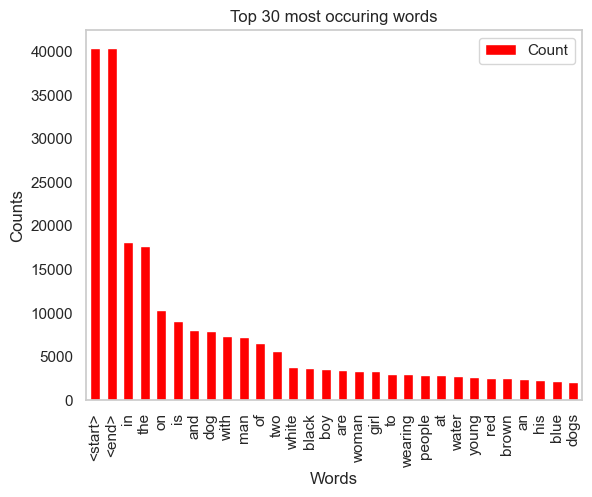

In [35]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

#your code here
tokenizer_top_words= [word for line in annotations for word in line.split()]

tokenizer_top_words_count=collections.Counter(tokenizer_top_words)
tokenizer_top_words_count

for word, count in tokenizer_top_words_count.most_common(30):
    print(word, ": ", count)

token_lst = tokenizer_top_words_count.most_common(30)
most_common_words_df = pd.DataFrame(token_lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word',y='Count',width=0.6,color='red')
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")
plt.grid(visible=None)

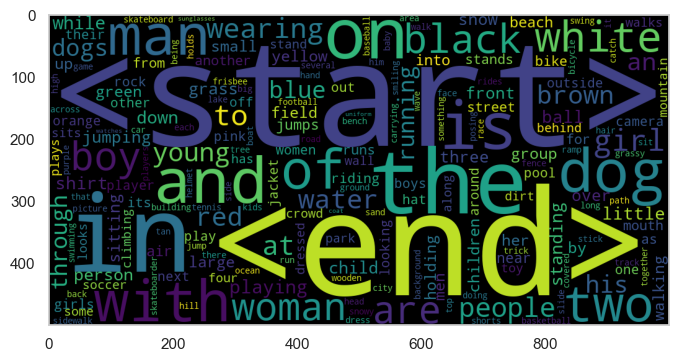

In [34]:
wordcloud_token = WordCloud(width = 1000, height = 500).generate_from_frequencies(tokenizer_top_words_count)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud_token)
plt.grid(visible=None)

In [36]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

train_seqs_len=[len(seq) for seq in train_seqs] #storing all lengths in list.Can be used if needed in future
longest_word_length= max(train_seqs_len) #Python list method max returns the elements from the list with maximum value.

# Calculates the longest_word_length to pad all sequences to be the same length as the longest one.

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post',maxlen=longest_word_length,
                                                          dtype='int32', value=0)

print("The shape of Caption vector is :" + str(cap_vector.shape))


The shape of Caption vector is :(40455, 31)


We are padding zero at last using padding='post'. We know that start token acts as prompter and it expect some word after tat.
Zero indicates no word and have no value at beginning.So,in order to not disturb the
existing sequence structure we pad at end. This padding will cause problem while creating embedding vector.So we will be applying mask then.

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [37]:
#checking to know about image format as we will be setting data format as none in tf.keras.applications.inception_v3.preprocess_input

tf.keras.backend.image_data_format() 

'channels_last'

Image data format have default as 'channels_last' which indicates Image data is represented in a three-dimensional array where the last channel represents the color channels, e.g. [rows][cols][channels].

In [38]:
IMAGE_SHAPE= (299, 299)

In [39]:
#write your code here
#Let's see how preprocessed image looks by preprocessing first 5 images alone.
preprocessed_img=[]
for img in all_imgs[0:5]:
    img = tf.io.read_file(img,name=None)
    # by default channels=0 which indictaes to use the number of channels in the JPEG-encoded image.
    img = tf.image.decode_jpeg(img,channels=0) #Since its RGB images,we can give channels=3 also which will output an RGB image.
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = tf.keras.applications.inception_v3.preprocess_input(img,data_format=None)#Default value for data format is None
    # It refers to global setting tf.keras.backend.image_data_format()
    preprocessed_img.append(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)


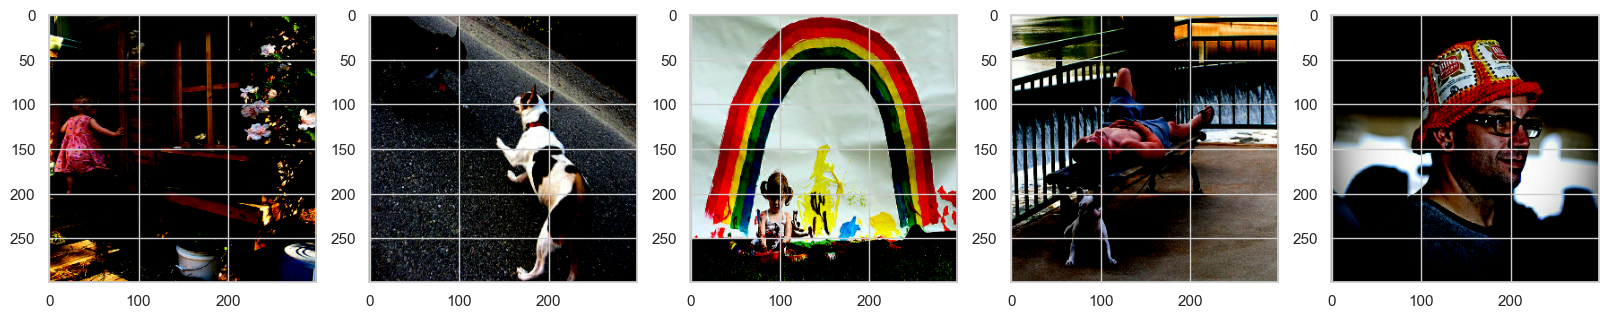

In [40]:
Display_Images= preprocessed_img[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)
   
for ax,image in zip(axes, Display_Images):
    print("Shape after resize :", image.shape)
    ax.imshow(image)
    ax.grid('off')

Let's write a function for preprocessing and return images and it's path so that we can 
use concept of ***vectorization and preprocess images paralleley rather than writing for loop***.

In [41]:
#write your code here

def preprocess_images_function(image_path):

    img = tf.io.read_file(image_path,name=None)
    # by default channels=0 which indictaes to use the number of channels in the JPEG-encoded image.
    #Since its RGB images,we can give channels=3 also which will output an RGB image.
    img = tf.image.decode_jpeg(img,channels=0) 
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = tf.keras.applications.inception_v3.preprocess_input(img,data_format=None) #Default value for data format is None
    # It refers to global setting tf.keras.backend.image_data_format()
    return img, image_path

## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [42]:
all_img_vector

['C:/Flickr8K/Images/1000268201_693b08cb0e.jpg',
 'C:/Flickr8K/Images/1000268201_693b08cb0e.jpg',
 'C:/Flickr8K/Images/1000268201_693b08cb0e.jpg',
 'C:/Flickr8K/Images/1000268201_693b08cb0e.jpg',
 'C:/Flickr8K/Images/1000268201_693b08cb0e.jpg',
 'C:/Flickr8K/Images/1001773457_577c3a7d70.jpg',
 'C:/Flickr8K/Images/1001773457_577c3a7d70.jpg',
 'C:/Flickr8K/Images/1001773457_577c3a7d70.jpg',
 'C:/Flickr8K/Images/1001773457_577c3a7d70.jpg',
 'C:/Flickr8K/Images/1001773457_577c3a7d70.jpg',
 'C:/Flickr8K/Images/1002674143_1b742ab4b8.jpg',
 'C:/Flickr8K/Images/1002674143_1b742ab4b8.jpg',
 'C:/Flickr8K/Images/1002674143_1b742ab4b8.jpg',
 'C:/Flickr8K/Images/1002674143_1b742ab4b8.jpg',
 'C:/Flickr8K/Images/1002674143_1b742ab4b8.jpg',
 'C:/Flickr8K/Images/1003163366_44323f5815.jpg',
 'C:/Flickr8K/Images/1003163366_44323f5815.jpg',
 'C:/Flickr8K/Images/1003163366_44323f5815.jpg',
 'C:/Flickr8K/Images/1003163366_44323f5815.jpg',
 'C:/Flickr8K/Images/1003163366_44323f5815.jpg',
 'C:/Flickr8K/Images

In [43]:
#write your code here
# mapping each image full path including name to the function to preprocess the image

# sorting and storing unique path in list which will be given as input 
training_list = sorted(set(all_img_vector)) 

# Creating a Dataset using tf.data.Dataset.from_tensor_slice
New_Image_Data = tf.data.Dataset.from_tensor_slices(training_list)


# Mappng preprocess_images_function across the elements of the above dataset.
# num_parallel_calls= tf.data.AUTOTUNE is used, then the number of parallel calls is set dynamically based on available CPU.
New_Image_Data = New_Image_Data.map(preprocess_images_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)


# Keeping batch_size=64 (64 consecutive elements of this dataset is combined in a single batch).
# We don't want to drop the last batch if it contains element less than 64.So let's set drop_remainder=False 
New_Image_Data= New_Image_Data.batch(64,drop_remainder=False)

In [44]:
New_Image_Data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [45]:
#sample_img_batch, sample_cap_batch = next(iter(New_Image_Data))
#print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
#print(sample_cap_batch.shape) #(batch_size, max_len)

In [46]:
#write your code here

# performing the train-test spliit using 80-20 ratio & random state = 42

img_train_data, img_test_data, caption_train_data, caption_test_data = train_test_split(all_img_vector,cap_vector,test_size=0.2,random_state=42)

In [47]:
print("No of images in training dataset: ",len(img_train_data))
img_train_data[0:5]


No of images in training dataset:  32364


['C:/Flickr8K/Images/359082432_c1fd5aa2d6.jpg',
 'C:/Flickr8K/Images/2460799229_ce45a1d940.jpg',
 'C:/Flickr8K/Images/3634828052_3b6aeda7d6.jpg',
 'C:/Flickr8K/Images/2216568822_84c295c3b0.jpg',
 'C:/Flickr8K/Images/3080056515_3013830309.jpg']

In [48]:
print("No of images in testing dataset: ",len(img_test_data))
img_test_data[0:5]

No of images in testing dataset:  8091


['C:/Flickr8K/Images/2973269132_252bfd0160.jpg',
 'C:/Flickr8K/Images/270263570_3160f360d3.jpg',
 'C:/Flickr8K/Images/2053006423_6adf69ca67.jpg',
 'C:/Flickr8K/Images/512101751_05a6d93e19.jpg',
 'C:/Flickr8K/Images/3156406419_38fbd52007.jpg']

In [49]:
print("No of captions in training dataset: ",len(caption_train_data))
caption_train_data[0:5]

No of captions in training dataset:  32364


array([[   2,   11,    8,    9,   17,   39,    6,  146,  148,  110,  542,
          46,   20,    5,  170,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,    5,   47,   95,  238,   17,   21,  472,  543,   17,   90,
          63,    5,   24,    3,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   18,   10,   94,   10,  283,  195, 2640,  278,  140,    3,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   18,   10,   26, 2236,  168,    8, 1869,  455, 1056,    6,
          62,  325,    3,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   80,   42,    7, 3255,   20,   72,    3,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        

In [50]:
print("No of captions in testing dataset: ",len(caption_test_data))
caption_test_data[0:5]

No of captions in testing dataset:  8091


array([[   2,   54, 1626,  588,    7, 4556,  223,  121, 1476,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   13,   27,   31,  500,    6,    5, 1681,  170,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   11,    4,  164,    7,   39,    6,   82,   90,   87,   23,
           5,  458,   74,    5, 3975,    3,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,  887,   14,    9,    7,   32,    6,    5,   41,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   42,  376,  727,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



**Inception v3 is a widely-used image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset. So let's also use same model to get feature vector.**


In [51]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

#image_features_extract_model = keras.Model(new_input, hidden_layer) #build the final model using both input & output layer
image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer)  #build the final model using both input & output layer


87910968/87910968 [==============================] - 12s 0us/step


In [52]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalization[0][0

 conv2d_11 (Conv2D)          (None, None, None, 32)       6144      ['average_pooling2d[0][0]']   
                                                                                                  
 batch_normalization_5 (Bat  (None, None, None, 64)       192       ['conv2d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_7 (Bat  (None, None, None, 64)       192       ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_10 (Ba  (None, None, None, 96)       288       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_17 (Activation)  (None, None, None, 96)       0         ['batch_normalization_17[0][0]
                                                                    ']                            
                                                                                                  
 activation_18 (Activation)  (None, None, None, 64)       0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 mixed1 (Concatenate)        (None, None, None, 288)      0         ['activation_12[0][0]',       
                                                                     'activation_14[0][0]',       
                                                                     'activation_17[0][0]',       
          

                                                                                                  
 conv2d_28 (Conv2D)          (None, None, None, 96)       55296     ['activation_27[0][0]']       
                                                                                                  
 batch_normalization_28 (Ba  (None, None, None, 96)       288       ['conv2d_28[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_28 (Activation)  (None, None, None, 96)       0         ['batch_normalization_28[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, None, None, 384)      995328    ['mixed2[0][0]']              
          

 conv2d_30 (Conv2D)          (None, None, None, 192)      147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_33 (Conv2D)          (None, None, None, 192)      172032    ['activation_32[0][0]']       
                                                                                                  
 conv2d_38 (Conv2D)          (None, None, None, 192)      172032    ['activation_37[0][0]']       
                                                                                                  
 conv2d_39 (Conv2D)          (None, None, None, 192)      147456    ['average_pooling2d_3[0][0]'] 
                                                                                                  
 batch_normalization_30 (Ba  (None, None, None, 192)      576       ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
          

                                                                    ']                            
                                                                                                  
 average_pooling2d_4 (Avera  (None, None, None, 768)      0         ['mixed4[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_40 (Conv2D)          (None, None, None, 192)      147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_43 (Conv2D)          (None, None, None, 192)      215040    ['activation_42[0][0]']       
                                                                                                  
 conv2d_48 (Conv2D)          (None, None, None, 192)      215040    ['activation_47[0][0]']       
          

                                                                                                  
 activation_52 (Activation)  (None, None, None, 160)      0         ['batch_normalization_52[0][0]
                                                                    ']                            
                                                                                                  
 activation_57 (Activation)  (None, None, None, 160)      0         ['batch_normalization_57[0][0]
                                                                    ']                            
                                                                                                  
 average_pooling2d_5 (Avera  (None, None, None, 768)      0         ['mixed5[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_50

 batch_normalization_62 (Ba  (None, None, None, 192)      576       ['conv2d_62[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_67 (Ba  (None, None, None, 192)      576       ['conv2d_67[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_62 (Activation)  (None, None, None, 192)      0         ['batch_normalization_62[0][0]
                                                                    ']                            
                                                                                                  
 activation_67 (Activation)  (None, None, None, 192)      0         ['batch_normalization_67[0][0]
          

                                                                                                  
 conv2d_71 (Conv2D)          (None, None, None, 320)      552960    ['activation_70[0][0]']       
                                                                                                  
 conv2d_75 (Conv2D)          (None, None, None, 192)      331776    ['activation_74[0][0]']       
                                                                                                  
 batch_normalization_71 (Ba  (None, None, None, 320)      960       ['conv2d_71[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_75 (Ba  (None, None, None, 192)      576       ['conv2d_75[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_82 (Activation)  (None, None, None, 384)      0         ['batch_normalization_82[0][0]
                                                                    ']                            
                                                                                                  
 activation_83 (Activation)  (None, None, None, 384)      0         ['batch_normalization_83[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_84 (Ba  (None, None, None, 192)      576       ['conv2d_84[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activatio

                                                                                                  
 activation_88 (Activation)  (None, None, None, 384)      0         ['batch_normalization_88[0][0]
                                                                    ']                            
                                                                                                  
 activation_91 (Activation)  (None, None, None, 384)      0         ['batch_normalization_91[0][0]
                                                                    ']                            
                                                                                                  
 activation_92 (Activation)  (None, None, None, 384)      0         ['batch_normalization_92[0][0]
                                                                    ']                            
                                                                                                  
 batch_nor

We are not classifying the images here. Rather,we only need to extract an image vector for our images.Hence we are removing the softmax layer from the model.

In [53]:
# write your code to extract features from each image in the dataset
image_features_dict={}
for image, image_path in tqdm(New_Image_Data): #using tqdm as progress bar
    features_for_batch = image_features_extract_model(image) #feeding images from above created dataset to Inception v3 which we build above
    #fb_shape = features_for_batch.get_shape().as_list()
    #features_for_batch_flattened = tf.contrib.layers.flatten(fb_shape) 
    features_for_batch_flattened = tf.reshape(features_for_batch,
                             (features_for_batch.shape[0], -1, features_for_batch.shape[3])) ##We are sqeezing/squashing 
                                   
    for batch_feat, path in zip(features_for_batch_flattened, image_path):
        feature_path = path.numpy().decode("utf-8")
        image_features_dict[feature_path] =  batch_feat.numpy()



100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [08:37<00:00,  4.08s/it]


In [54]:
features_for_batch

<tf.Tensor: shape=(27, 8, 8, 2048), dtype=float32, numpy=
array([[[[0.00000000e+00, 7.74662197e-02, 0.00000000e+00, ...,
          2.31837645e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.07787728e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.94033504e-01, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 1.85754776e-01],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          9.42662954e-02, 0.00000000e+00, 5.05790830e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 4.23005670e-01, 1.34464502e-02, ...,
          2.33669966e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         

In [55]:
features_for_batch_flattened

<tf.Tensor: shape=(27, 64, 2048), dtype=float32, numpy=
array([[[0.0000000e+00, 7.7466220e-02, 0.0000000e+00, ...,
         2.3183765e-01, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.0778773e-01, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 1.9403350e-01, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 1.8575478e-01],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 1.6569382e+00, 0.0000000e+00],
        [0.0000000e+00, 4.0261045e-01, 0.0000000e+00, ...,
         0.0000000e+00, 3.1791970e-01, 0.0000000e+00],
        [0.0000000e+00, 2.5347557e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.2506015e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 7.8496963e-02, ...,
         1.2064192e+00, 0.0000000e+00, 0.0000000e+00],
        [0.000000

In [56]:
len(image_features_dict)

8091

In [57]:
batch_feat.shape

TensorShape([64, 2048])

In [61]:
pip install more-itertools

     ---------------------------------------- 57.0/57.0 kB 1.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [62]:
import more_itertools
top_5_items = more_itertools.take(5, image_features_dict.items())

top_5_items #printing first 5 elememts have dictionary

[('C:/Flickr8K/Images/1000268201_693b08cb0e.jpg',
  array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.16987033],
         [0.        , 0.        , 1.0105923 , ..., 0.        , 0.        ,
          0.06111681],
         ...,
         [0.        , 0.        , 2.038045  , ..., 1.2029712 , 0.        ,
          1.992414  ],
         [0.        , 0.        , 0.9046917 , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 1.2527282 , 0.        , ..., 0.        , 0.        ,
          0.        ]], dtype=float32)),
 ('C:/Flickr8K/Images/1001773457_577c3a7d70.jpg',
  array([[0.        , 0.6636802 , 0.46286002, ..., 0.        , 0.        ,
          3.3322637 ],
         [0.        , 1.226817  , 0.        , ..., 0.        , 0.25390273,
          3.3295367 ],
         [1.2881975 , 1.5195404 , 0.        , ..., 0.46778142, 0.36474553,
         

In [63]:
#we need to give both images and caption to model as input
def model_input(image,captions):
    image_final = image_features_dict[image.decode('utf-8')]
    return image_final,captions

In [64]:
# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 1000

# Batch size
BATCH_SIZE = 64 ##tried with different batch sizes.kernal is dieing for 32 .So finally fixed 64.

def data_generator(images_data, captions_data):
    
    # Creating a Dataset using tf.data.Dataset.from_tensor_slice 
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))

    # num_parallel_calls= tf.data.AUTOTUNE is used, then the number of parallel calls is set dynamically based on available CPU.
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(model_input, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # reshuffle_each_iteration=True indicate Shuffle order should be different for each epoch.
    # Keeping batch_size=64 (64 consecutive elements of this dataset is combined in a single batch).
    # We don't want to drop the last batch if it contains element less than 64.So let's set drop_remainder=False 
    # Prefetch function is used to prepare later elements while the current element is being processed.
    
    dataset = (
     dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True) 
    .batch(BATCH_SIZE, drop_remainder=False)
    .prefetch(tf.data.experimental.AUTOTUNE)
    ) 

    return dataset

In [65]:
train_dataset=data_generator(img_train_data,caption_train_data) 
test_dataset=data_generator(img_test_data,caption_test_data) 

In [66]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(64, 64, 2048)
(64, 31)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [67]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(img_train_data) // BATCH_SIZE  #len(total train images) // BATCH_SIZE
test_num_steps = len(img_test_data) // BATCH_SIZE   #len(total test images) // BATCH_SIZE
max_length=31
features_shape = batch_feat.shape[1]
attention_features_shape = batch_feat.shape[0]

### Encoder

In [68]:
tf.compat.v1.reset_default_graph() #to resolve compatibility issue
#from tensorflow.python.framework import ops
#ops.reset_default_graph()
#tf.compat.v1.GraphDef()

In [69]:
print(tf.compat.v1.get_default_graph())


PyGraph<1673263315840>


In [70]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        #It acts as the fully connected layer
        
    def call(self, features):
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0) #applying relu activation 
        return features

In [71]:
encoder=Encoder(embedding_dim)

In [77]:
from keras.utils import plot_model 

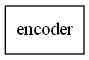

In [82]:
from keras.utils import plot_model 
plot_model(encoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Attention model

In [78]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 =  tf.keras.layers.Dense(units)#build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1)#build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis=hidden[:, tf.newaxis] # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score =tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))# build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)# reduce the shape to (batch_size, embedding_dim)
        # the tensor is reduced along the second dimension (columns)

        return context_vector, attention_weights


The attention model does a linear transformation of the input.So we are applying tanh function on top of it.The features produced from dense layer(FC layer) of encoder and hidden state of decoder are passed to tanh function and attention score is calculated

In other words, the tanh function is introduced to do non linear transformation and give smooth output .Since we need output in range (0,1), we apply softmax function on the obtained attention score which now gives the atttention weights.

Finally we computed a weighted sum of the attention weights on the feature vector and thus, derived our context vector.

This context vector produced are adaptive as they change for each and every time stamp. 

### Decoder

In [79]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)   #build your Dense layer

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)#create your context vector & attention weights from attention model
        embed = self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


We know that the encoder output along with hidden state is passed to attention model.The attention model produces context vector.This context vector is concatenated with embedded vector formed from embedding layer and passed to GRU.After passing 
the GRU output to dense layers,finally we are trying to obtain output in shape of vocab_size as we need to assign probabilities for each and every word in vocabulary.

In [80]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [81]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [84]:
optimizer =tf.keras.optimizers.Adam(learning_rate=0.001) #define the optimizer
loss_object =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction=tf.keras.losses.Reduction.NONE) #define your loss object
#we always need to choose appropriate loss function.Let us use crossentropy SparseCategoricalCrossentropy.
# It calculates loss between the labels and predictions.

In [85]:
# zero is causing discrepency.we dont want decoder to give importance to zero.so lets mask zero to false

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask # we are multiplying loss with mask to get ideal shape

    return tf.reduce_mean(loss_)

In [86]:
#path='https://upgrad.nimblebox.ai/project/upg-aruna-4881-21712/tree?/checkpoint'
#os.mkdir(path)

checkpoint_path = "Flickr8K/checkpoint1"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [87]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [88]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    #hidden = decoder.reset_state(batch_size=target.shape[0]) #we dont have reset_state method
    hidden = decoder.init_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: #Record operations for automatic differentiation for implementing backpropagation
        #write your code here to do the training steps
        encoder_output = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder
        for t in range(1, target.shape[1]):
          # passing encoder_output to the decoder
          predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)

          loss += loss_function(target[:, t], predictions)

          dec_input = tf.expand_dims(target[:, t], 1)
    
    avg_loss = (loss / int(target.shape[1])) #we are calculating average loss for every batch

    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables
    
    grads = tape.gradient(loss, tot_trainables_variables) # to calculate gradients with respect to every trainable variable

    #compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables)) 
        
    return loss, avg_loss

In [89]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    #hidden = decoder.reset_state(batch_size=target.shape[0]) #we dont have reset_state method
    hidden = decoder.init_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape: #Record operations for automatic differentiation.
        #write your code here to do the training steps
        encoder_output = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder.
        for t in range(1, target.shape[1]):
          # passing encoder_output to the decoder
          predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)

          loss += loss_function(target[:, t], predictions) 

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, t], 1)
    
    avg_loss = (loss / int(target.shape[1]))#we are calculating average loss for every batch

    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables

    grads = tape.gradient(loss, tot_trainables_variables) # to calculate gradients with respect to every trainable variable

    #compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables))
        
    return loss, avg_loss

We are using teacher forcing as training converges faster. Also, in the initial steps of training, the predictions of the model are very bad. If we are not using it, the hidden states of the model might be updated with the sequence of wrong predictions because of the relational understading present between words, and this mislead the model as errors will keep on adding, and the model will learn wrongly and perform badly at the end.So in order to train the model in right direction, we are doing this tweaking and forcing the model to predict correctly by passing the target word as the next input to the decoder

In [90]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss=total_loss / test_num_steps
    
    return avg_test_loss

In [91]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.433, & test loss is 1.197
Time taken for 1 epoch 1120.9401257038116 sec

Test loss has been reduced from 100.000 to 1.197


  7%|█████▎                                                                         | 1/15 [18:41<4:21:47, 1121.99s/it]

For epoch: 2, the train loss is 1.106, & test loss is 1.054
Time taken for 1 epoch 1303.9560956954956 sec

Test loss has been reduced from 1.197 to 1.054


 13%|██████████▌                                                                    | 2/15 [40:26<4:26:22, 1229.45s/it]

For epoch: 3, the train loss is 1.003, & test loss is 0.970
Time taken for 1 epoch 1519.492288351059 sec

Test loss has been reduced from 1.054 to 0.970


 20%|███████████████▍                                                             | 3/15 [1:05:46<4:32:25, 1362.10s/it]

For epoch: 4, the train loss is 0.930, & test loss is 0.904
Time taken for 1 epoch 1603.9823653697968 sec

Test loss has been reduced from 0.970 to 0.904


 27%|████████████████████▌                                                        | 4/15 [1:32:31<4:27:16, 1457.87s/it]

For epoch: 5, the train loss is 0.870, & test loss is 0.848
Time taken for 1 epoch 1660.6274056434631 sec

Test loss has been reduced from 0.904 to 0.848


 33%|█████████████████████████▋                                                   | 5/15 [2:00:12<4:15:11, 1531.18s/it]

For epoch: 6, the train loss is 0.818, & test loss is 0.805
Time taken for 1 epoch 1690.3478274345398 sec

Test loss has been reduced from 0.848 to 0.805


 40%|██████████████████████████████▊                                              | 6/15 [2:28:23<3:57:49, 1585.47s/it]

For epoch: 7, the train loss is 0.772, & test loss is 0.754
Time taken for 1 epoch 1536.4454941749573 sec

Test loss has been reduced from 0.805 to 0.754


 47%|███████████████████████████████████▉                                         | 7/15 [2:54:00<3:29:17, 1569.72s/it]

For epoch: 8, the train loss is 0.727, & test loss is 0.709
Time taken for 1 epoch 1434.2061004638672 sec

Test loss has been reduced from 0.754 to 0.709


 53%|█████████████████████████████████████████                                    | 8/15 [3:17:55<2:58:07, 1526.74s/it]

For epoch: 9, the train loss is 0.685, & test loss is 0.670
Time taken for 1 epoch 1433.5240876674652 sec

Test loss has been reduced from 0.709 to 0.670


 60%|██████████████████████████████████████████████▏                              | 9/15 [3:41:49<2:29:46, 1497.75s/it]

For epoch: 10, the train loss is 0.647, & test loss is 0.633
Time taken for 1 epoch 1439.2452669143677 sec

Test loss has been reduced from 0.670 to 0.633


 67%|██████████████████████████████████████████████████▋                         | 10/15 [4:05:49<2:03:19, 1479.84s/it]

For epoch: 11, the train loss is 0.612, & test loss is 0.597
Time taken for 1 epoch 1458.5549523830414 sec

Test loss has been reduced from 0.633 to 0.597


 73%|███████████████████████████████████████████████████████▋                    | 11/15 [4:30:08<1:38:14, 1473.51s/it]

For epoch: 12, the train loss is 0.578, & test loss is 0.567
Time taken for 1 epoch 1432.438039302826 sec

Test loss has been reduced from 0.597 to 0.567


 80%|████████████████████████████████████████████████████████████▊               | 12/15 [4:54:01<1:13:03, 1461.17s/it]

For epoch: 13, the train loss is 0.548, & test loss is 0.538
Time taken for 1 epoch 1424.206698179245 sec

Test loss has been reduced from 0.567 to 0.538


 87%|███████████████████████████████████████████████████████████████████▌          | 13/15 [5:17:45<48:20, 1450.14s/it]

For epoch: 14, the train loss is 0.520, & test loss is 0.511
Time taken for 1 epoch 1427.6315596103668 sec

Test loss has been reduced from 0.538 to 0.511


 93%|████████████████████████████████████████████████████████████████████████▊     | 14/15 [5:41:34<24:03, 1443.51s/it]

For epoch: 15, the train loss is 0.494, & test loss is 0.486
Time taken for 1 epoch 1429.6921684741974 sec

Test loss has been reduced from 0.511 to 0.486


100%|██████████████████████████████████████████████████████████████████████████████| 15/15 [6:05:24<00:00, 1461.63s/it]


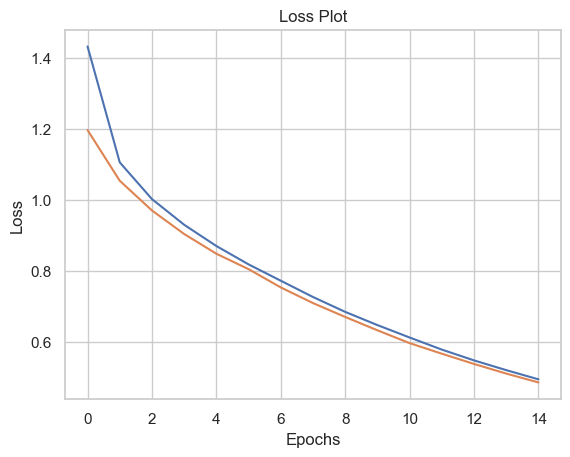

In [92]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.grid('off')
plt.show()


## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [93]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    #hidden = decoder.reset_state(batch_size=1)
    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_images_function(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id =  tf.argmax(predictions[0]).numpy()#extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id])#map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [94]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [95]:
from nltk.translate.bleu_score import sentence_bleu

In [96]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [97]:
img_test=img_test_data.copy()

In [98]:
#modifying the given code as function to run it several times by changing weights
def predicted_caption_audio(random,autoplay=False,weights=(0.5, 0.5, 0, 0)):

    cap_test=caption_test_data.copy()
    rid = np.random.randint(0, random)
    test_image = img_test[rid]
    #test_image = 'Flickr8K/Images/413231421_43833a11f5.jpg'
    #real_caption = '<start> black dog is digging in the snow <end>'

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)

    real_caption=filt_text(real_caption)      

    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights=weights)#set your weights)
    print(f"BELU score: {score*100}")

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    plot_attmap(result, attention_plot, test_image)

    #Let's use Google Text to Speech Online API from playing the predicted caption as audio
    speech = gTTS("Predicted Caption is: "+ pred_caption,lang = 'en', slow = False) 
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'
    #playsound('voice.wav')
    display.display(display.Audio(audio_file, rate=None,autoplay=autoplay))
    
    return test_image

BELU score: 78.41475134249411
Real Caption: muzzled white dog is running on the grass
Prediction Caption: white dog with muzzle is running on the grass


C:\Users\amlan\AppData\Local\Temp\ipykernel_21376\1530701205.py:9: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))


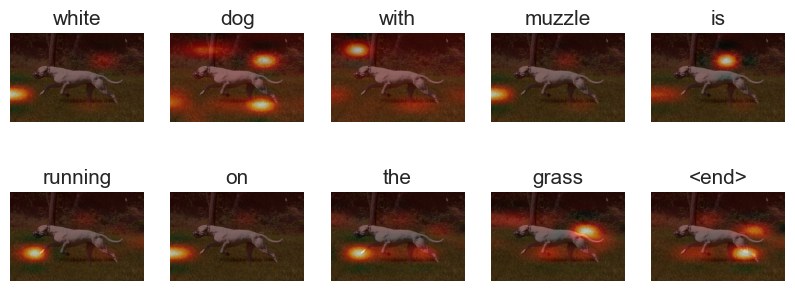

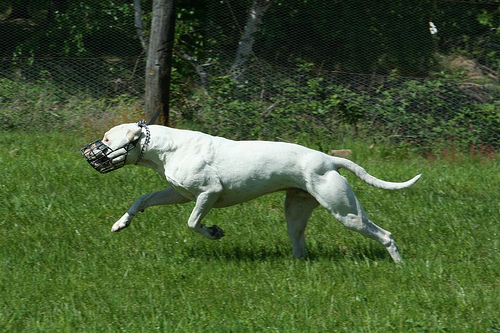

In [100]:
test_image=predicted_caption_audio(5,True,weights=(0.5,0.25,0,0))

Image.open(test_image)

BELU score: 100.0
Real Caption: boy hits tennis ball with his tennis racquet
Prediction Caption: boy hits tennis ball with his tennis racquet


C:\Users\amlan\AppData\Local\Temp\ipykernel_21376\1530701205.py:9: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))


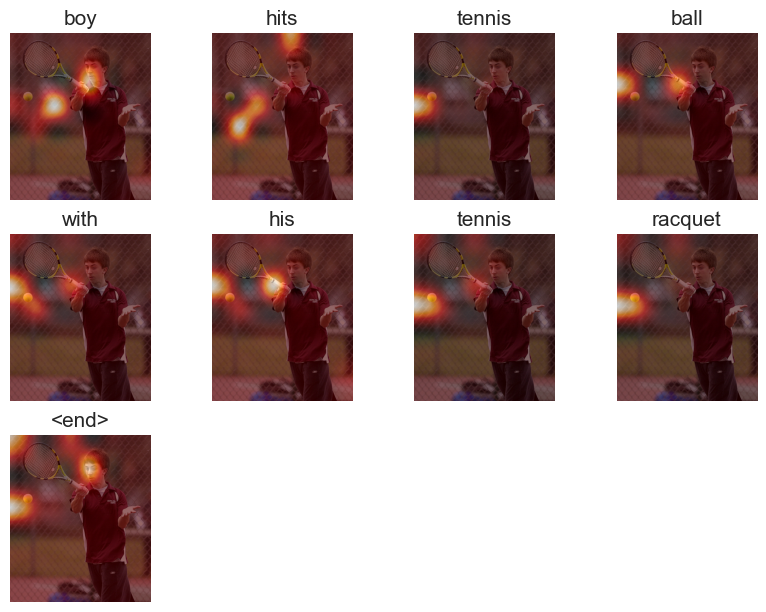

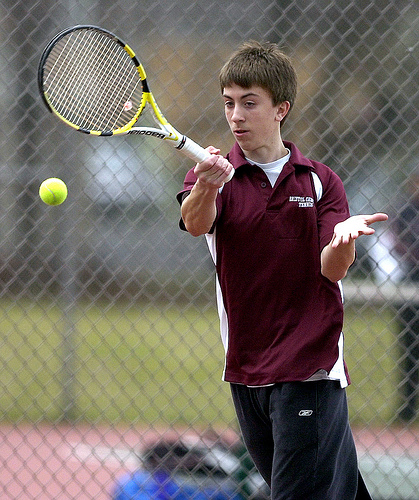

In [103]:
test_image=predicted_caption_audio(len(img_test),False,weights=(0.5,0.25,0,0))

Image.open(test_image)

C:\Users\amlan\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\amlan\AppData\Local\Temp\ipykernel_21376\1530701205.py:9: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))


BELU score: 100.0
Real Caption: closeup of hummingbird
Prediction Caption: closeup of hummingbird


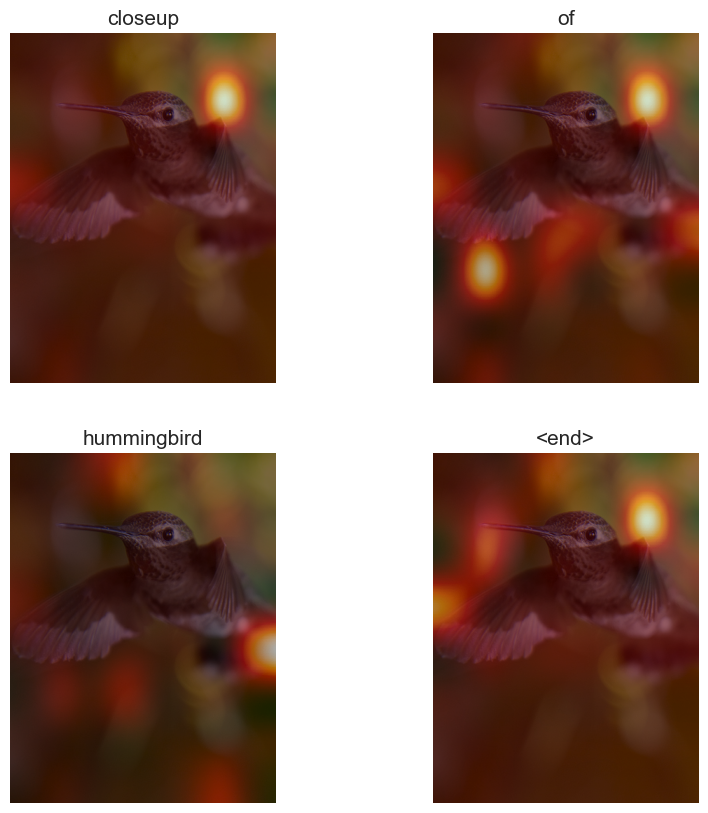

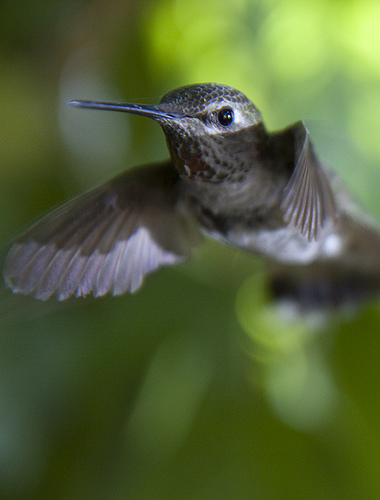

In [104]:
test_image1=predicted_caption_audio(len(img_test),False,weights=(0.25,0.25,0,0))

Image.open(test_image1)

BELU score: 51.3417119032592
Real Caption: blond child runs down sand dune while another looks on
Prediction Caption: blond child runs down sand dune


C:\Users\amlan\AppData\Local\Temp\ipykernel_21376\1530701205.py:9: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))


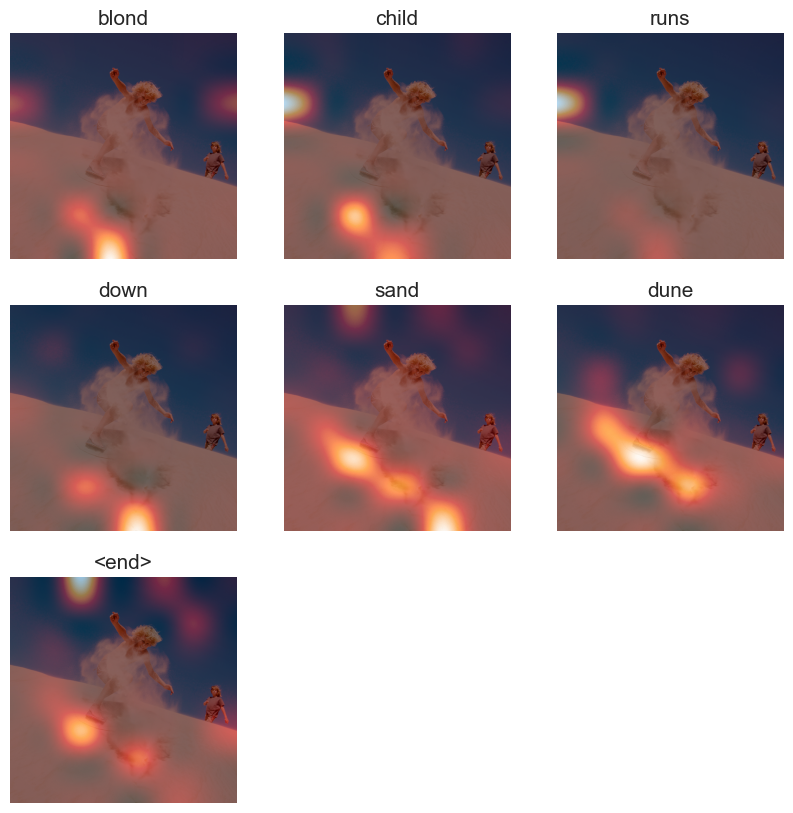

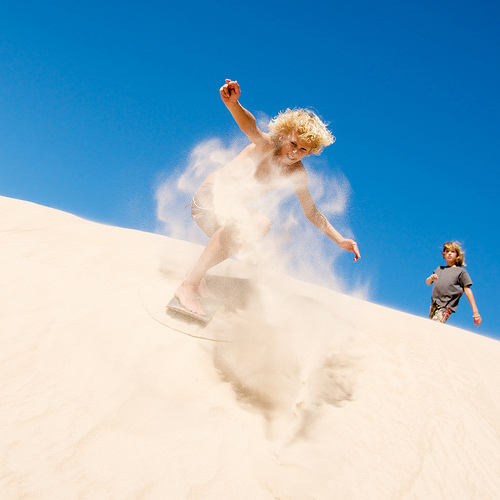

In [108]:
test_image=predicted_caption_audio(len(img_test),False,weights=(0.5,0.25,0,0))

Image.open(test_image)

BELU score: 45.64354645876384
Real Caption: little boy is hanging off red playground
Prediction Caption: boy smiles as other children hanging off red playground


C:\Users\amlan\AppData\Local\Temp\ipykernel_21376\1530701205.py:9: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))


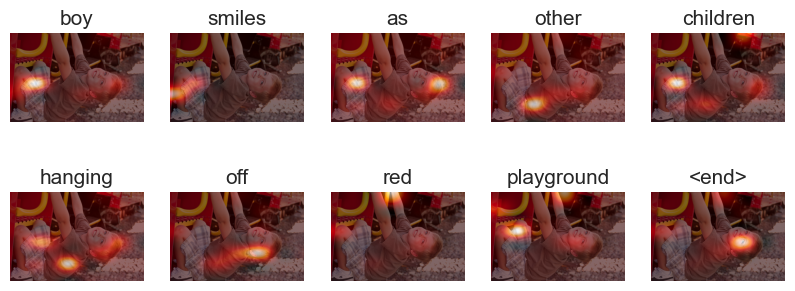

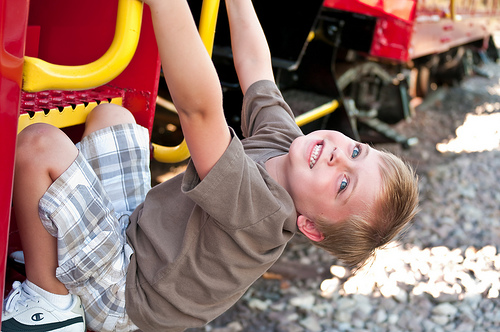

In [116]:
test_image=predicted_caption_audio(len(img_test),False,weights=(0.5,0.5,0,0))

Image.open(test_image)


BELU score: 81.6496580927726
Real Caption: boy does skateboard tricks at sundown
Prediction Caption: man does skateboard tricks at sundown


C:\Users\amlan\AppData\Local\Temp\ipykernel_21376\1530701205.py:9: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))


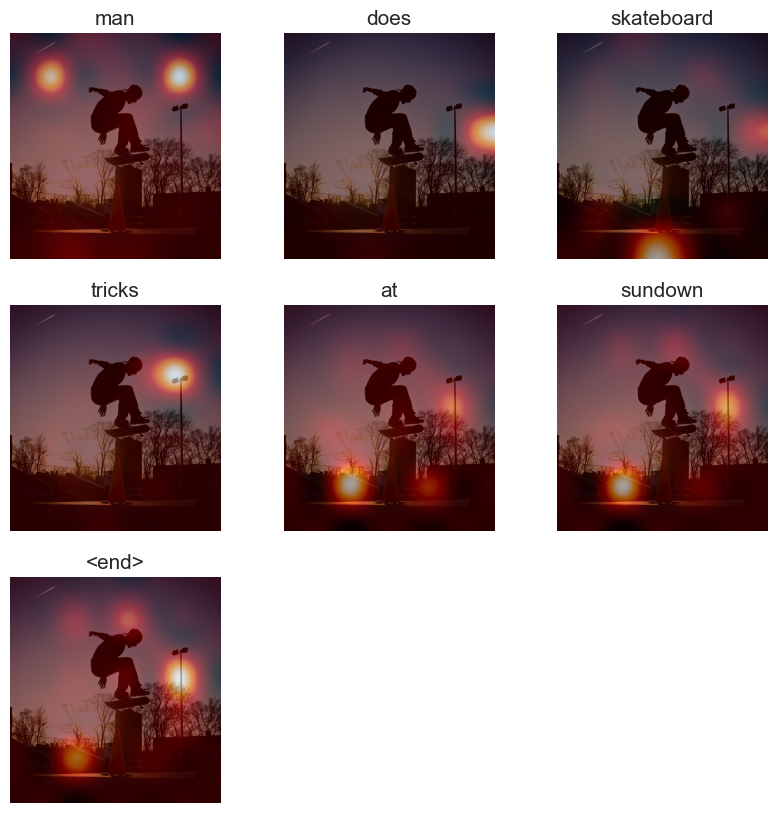

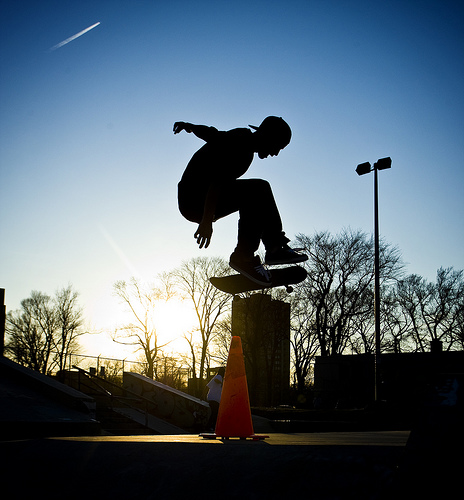

In [124]:
test_image=predicted_caption_audio(len(img_test),False,weights=(0.5,0.5,0,0))

Image.open(test_image)

### Summary: 

The project commenced with the reading and display of images and captions. An Exploratory Data Analysis (EDA) was conducted to gain insights into the provided dataset. This was followed by data cleaning, which involved tidying up the caption file.

Data preprocessing was also carried out, which encompassed:

- Tokenizing the captions and forming an embedded vector,
- Preprocessing the images.
Subsequently, the dataset was divided into training and testing subsets.

The InceptionV3 model was employed. Inception v3 is a renowned image recognition model that has demonstrated over 78.1% accuracy on the ImageNet dataset. Therefore, the same model was used to obtain the feature vector.

In this project, the objective was not to classify the images, but to extract a feature vector from them. Consequently, the softmax layer was removed from the model. The output of this layer was of the shape 8x8x2048, which was then squeezed to a shape of (64, 2048).

This feature vector was fed into the CNN Encoder, which consisted of a single fully connected layer. In abstract terms, the output from the encoder, the hidden state (initialized to 0), and the start token were passed as inputs to the decoder.

The decoder (an RNN - in this case, a GRU) attended over the image to predict the next word. An attention model was used to enable the decoder to focus on specific parts of the image at a time, rather than the entire image. This reduced noise and enhanced accuracy. The decoder returned the predicted caption and the decoder's hidden state as output. These were sent back to the model, and the predictions were used to compute the loss using the cross-entropy "SparseCategoricalCrossentropy". Teacher forcing was also employed to determine the next input to the decoder.

The decoder ceased predicting when the model predicted the end token.

The model predicted words by determining their probabilities in the vocabulary. A greedy search method was used for this purpose. It calculated the probability of the words based on their occurrence in the vocabulary. It sampled the words, computed the probability of each word, and then outputted the word with the highest probability.

Finally, the "BLEU score" (Bilingual Evaluation Understudy) was used as the evaluation metric for the predicted word. It assessed the difference between the predicted caption and the actual caption.

-----------------------------------------------------------------------------------------------------------------------